## Feature extraction with Data Augmentation

Since the Respiratory data set is sparse on type of diseases, and in order to build a sufficient data set for further ML and DL processings, we run data augmentation processes of those sparse audio types, in order to generate synthetic data from the real recorded data by adding small perturbations.
Data augmentation strategies on audio files are based on:
- add noise, 
- stretch and roll (future), 
- pitch shift (future).

In [71]:
dataset_path='/Users/famillenassivet/Documents/bruno/Certifications/coursera/Data Science/Capstone/dataset/Respiratory_dataset/'
demographic_info_file_name='demographic_info.txt'
patient_diagnosis_file_path=dataset_path + 'Respiratory_Sound_Database/'
patient_diagnosis_file_name='patient_diagnosis.csv'
audio_file_directory_path=dataset_path + 'Respiratory_Sound_Database/audio_and_txt_files/'
dataset_export_path='/Users/famillenassivet/Documents/bruno/Certifications/coursera/Data Science/Capstone/dataset/Respiratory_dataset/respiratory-sound-database-export/export/'


audio_file_directory_path

'/Users/famillenassivet/Documents/bruno/Certifications/coursera/Data Science/Capstone/dataset/Respiratory_dataset/Respiratory_Sound_Database/audio_and_txt_files/'

In [72]:
import findspark
findspark.init()
import pyspark

In [73]:
sc = pyspark.SparkContext(appName="RespiratoryDataAnalysis",
                         master="local[2]").getOrCreate()
sc

<SparkContext master=local[2] appName=RespiratoryDataAnalysis>

In [74]:
from pyspark import SQLContext
sql_c = SQLContext(sc)

In [75]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType
from pyspark.sql import DataFrame as df
from pyspark.sql import *

In [76]:
import os
import io
import pywt
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import soundfile as sf

### Data augmentation functions

In [77]:
import numpy as np

In [78]:
def add_white_noise(data, ampl):
    """
    add a gaussian noise with amplitude ampl to a 1D sample data array
    """
    import numpy as np
    from numpy import random
    return data + ampl*random.randn(len(data))

In [79]:
def stretch(data, rate=1):
    """
    Stretch the sound by the 'rate' factor 
    """
    import numpy as np
    
    input_length = len(data)
    data_st = librosa.effects.time_stretch(np.asarray(data), rate)
    if len(data_st)>input_length:
        data_st = data_st[:input_length]
    else:
        data_st = np.pad(data_st, (0, max(0, input_length - len(data_st))), "constant")

    return data_st.tolist()


In [80]:
def roll(data, rolling_coef=0.05):
    """
    Shift elements of the signal.
    The number of shifted elements is its length multiplied by the rolling_coef
    """
    import numpy as np
    
    return np.roll(np.asarray(data), rolling_coef*len(data)).tolist()


In [81]:
def generate_synthetic_sample(data):
    """
    Generate a synthetic sample from the inout data.
    A combination of the available transformations are randomly chosen and applied to the inout sample.
    The following parameters are randomly chosen
    white_noise: ampl [0-5]
    stretch: rate= [0.8;1.2]
    roll: rolling_coef [0.05;0.10]
    """
    ## functions = np.random.permutation([white_noise, stretch, roll])
    import numpy as np
    from numpy import random
    
    synthetic_data = data
    if np.random.random_sample() > 0.2:
        synthetic_data = add_white_noise(synthetic_data, 5*random.rand(1))
    if np.random.random_sample() > 0.2:
        synthetic_data = stretch(synthetic_data,
                                 rate=0.8 +0.4*random.rand(1))
    #if np.random.random_sample() > 0.5:
    #    synthetic_data = roll(np.asarray(synthetic_data), 0.05+0.05*random.rand(1)).tolist()
        
    return synthetic_data
    

In [82]:
patient_diagnosis_schema = StructType([
    StructField("patientIdStr", StringType()),
    StructField("diagnosis", StringType())])

In [83]:
patient_diagnosis_df = sql_c.read.format("csv").schema(patient_diagnosis_schema).load(patient_diagnosis_file_path+patient_diagnosis_file_name)

In [84]:
patient_diagnosis_df = patient_diagnosis_df.withColumn("patientId", patient_diagnosis_df["patientIdStr"].cast("double"))

In [85]:
from pyspark.ml.feature import StringIndexer
df = patient_diagnosis_df.alias("df")

indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosisIndex")
patient_diagnosis_df = indexer.fit(patient_diagnosis_df).transform(patient_diagnosis_df)

In [86]:
patient_diagnosis_df.printSchema()

root
 |-- patientIdStr: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- patientId: double (nullable = true)
 |-- diagnosisIndex: double (nullable = false)



Now parsing audio file names and their annotation files
Filename format has 5 data:
Patient number (101,102,...,226)
Recording index
Chest location a. Trachea (Tc) b. Anterior left (Al) c. Anterior right (Ar) d. Posterior left (Pl) e. Posterior right (Pr) f. Lateral left (Ll) g. Lateral right (Lr)
Acquisition mode a. sequential/single channel (sc), b. simultaneous/multichannel (mc)
Recording equipment a. AKG C417L Microphone (AKGC417L), b. 3M Littmann Classic II SE Stethoscope (LittC2SE), c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200), d. WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)
The annotation text files have four columns:
Beginning of respiratory cycle(s)
End of respiratory cycle(s)
Presence/absence of crackles (presence=1, absence=0)
Presence/absence of wheezes (presence=1, absence=0)

The following libraries are used to process the dataset:
- glob: directories and files I/O
- soundfile: read .wav file; see https://pysoundfile.readthedocs.io/en/0.9.0/
- librosa: resample audio files; used for audio signals normalization; see https://librosa.github.io/librosa/
- numpy
- scikit-learn: ML

Note: TODO: enhance using sc.wholeTextFiles

In [87]:
target_length = 20000 # approximately 5sec for a rate of 4000
target_rate = 12000

## Feature extraction from audio sample

Sound feature is constructed from audio_list (constructed as: [file_name_base, patientId, recordId, sample_data]) augmented with diagnosisIndex. The sample data is also refactored to be sampled at rate target_rate=4000 and split in smaller records of size target_length.

In [88]:
def resample (sample, sample_rate, target_rate):
    # fonction to resample a time serie and return the corresponding mfcc
    from librosa import core as lcore
    if target_rate != sample_rate:
        resampled = lcore.resample(np.asarray(sample),\
                               orig_sr=sample_rate,\
                               target_sr=target_rate).tolist()
    else:
        resampled = sample    
    return resampled, target_rate

In [89]:
def mfcc (sample, sample_rate, n_mfcc=128):
    # fonction to resample a time serie and return the corresponding mfcc

    mfcc = librosa.feature.mfcc(y=np.asarray(sample), sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc

In [90]:
def resample_and_mfcc (sample, sample_rate, target_rate):
    # fonction to resample a time serie and return the corresponding mfcc
    from librosa import core as lcore
#    sample = librosa.to_mono(np.asarray(sample))
    resampled = lcore.resample(np.asarray(sample),\
                           orig_sr=sample_rate,\
                           target_sr=target_rate)
#    stft_out = librosa.amplitude_to_db(np.abs(librosa.stft(resampled)), ref=np.max)
    mfcc = librosa.feature.mfcc(y=resampled, sr=target_rate, n_mfcc=128)
    return mfcc

In [91]:
def split_sample(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

In [92]:
def extract_samples (sample_in, target_length, subsamples_nb=10):
    sample_out = []
    remaining_len = len(sample_in)
    parsed_len = 0
    while remaining_len >= target_length:
        sample_out.append(sample_in[parsed_len:parsed_len + target_length])
        remaining_len -= target_length
        parsed_len += target_length
        if len(sample_out) == subsamples_nb:
            remaining_len = 0
    if remaining_len > target_length / 2 :
        copy = np.zeros(target_length, dtype = np.float32)
        copy[:remaining_len] = sample_in[parsed_len:parsed_len+remaining_len]
        sample_out.append(copy.tolist())
    return sample_out

In [93]:
separator = '_'
audio_file_fields = []
audio_list =[]
for file_name in glob.iglob(audio_file_directory_path + '*.wav', recursive=False):
    file_name_base = os.path.basename(file_name)
    fileId = file_name_base.split('.')[0]
    file_field = fileId.split(separator)
    file_field.append(fileId)
    file_field.append(file_name_base)
    #reading audio file
    print('.', end='')
    data, sample_rate = librosa.load(file_name, mono='True')
    data, sample_rate = resample (data, sample_rate, target_rate)
    file_field.append(sample_rate)
    file_field.append(len(data))
    audio_list.append([file_name_base, file_field[0], file_field[1], sample_rate, data])
    audio_file_fields.append(file_field)

audio_file_fields[:2]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[['122',
  '2b1',
  'Tc',
  'mc',
  'LittC2SE',
  '122_2b1_Tc_mc_LittC2SE',
  '122_2b1_Tc_mc_LittC2SE.wav',
  12000,
  240001],
 ['113',
  '1b1',
  'Lr',
  'sc',
  'Litt3200',
  '113_1b1_Lr_sc_Litt3200',
  '113_1b1_Lr_sc_Litt3200.wav',
  12000,
  174913]]

In [94]:
diag_index = patient_diagnosis_df.select('patientId', 'diagnosisIndex').orderBy('patientId').dropDuplicates().rdd.map(lambda x : (x.patientId, x.diagnosisIndex)).collect()

In [95]:
patient_diag_dict = {}
for index in range(len(diag_index)):
    patient_diag_dict[diag_index[index][0]] = diag_index[index][1]
    
patient_diag_dict[101.0]

2.0

In [96]:
splitted_samples = []
length = len(audio_list)
for audio_index in range(length):
    print('.', end='')
    if audio_index % 100 == 0:
        print(str(audio_index) + "/" + str(length), end='')

    file_name_base = audio_list[audio_index][0]
    patientId = float(audio_list[audio_index][1])
    diagnosisIndex = patient_diag_dict[patientId]
    sample_rate = audio_list[audio_index][3]
    sample = audio_list[audio_index][4]
    splitted_sample = extract_samples(sample, \
                                   target_length)
    for sample_id in range(len(splitted_sample)):
        splitted_samples.append([file_name_base, sample_id, patientId, diagnosisIndex, sample_rate, splitted_sample[sample_id]])

.0/920....................................................................................................100/920....................................................................................................200/920....................................................................................................300/920....................................................................................................400/920....................................................................................................500/920....................................................................................................600/920....................................................................................................700/920....................................................................................................800/920....................................................................................................900/920...................

In [97]:
len(splitted_samples)

9171

Now we target a minimum of TARGET_SAMPLE samples per diagnosis type.
For each type which sample number is below TARGET_SAMPLE, synthetic samples are generated. 
TARGET_SAMPLE is set to 1000. 
Also, in order to have samples with no augmentation, only a ratio AUGMENTATION_RATIO of the samples is augmented.
A indicator recSource is kept to trace the oriogin of the sample: 
{0: original record with no augmentation, 
 1: original record used for augmention,
 2: augmented record}

In [98]:
TARGET_SAMPLE = 1000
AUGMENTATION_RATIO = 0.8

In [99]:
import pandas as pd
ss_df = pd.DataFrame(splitted_samples, columns= ['filename', 'sampleId', 'patientId', 'diagnosisIndex', 'sample_rate', 'recSample'])

In [100]:
len(ss_df)

9171

In [101]:
fileSource = pd.Series(1 , range(len(ss_df)), name='recSource')
ss_df = pd.concat([ss_df, fileSource], axis=1)

In [102]:
diag_count = ss_df.groupby('diagnosisIndex')
diag_count_df = diag_count.count()

Before data augmentation, the repartition of samples per type is given below.

In [103]:
diag_count_df

,filename,sampleId,patientId,sample_rate,recSample,recSource
diagnosisIndex,,,,,,
0.0,7901,7901,7901,7901,7901,7901
1.0,350,350,350,350,350,350
2.0,230,230,230,230,230,230
3.0,160,160,160,160,160,160
4.0,130,130,130,130,130,130
5.0,370,370,370,370,370,370
6.0,20,20,20,20,20,20
7.0,10,10,10,10,10,10


In [104]:
diag_count_df.loc[[0], ['patientId']].values[0][0]

7901

In [105]:
diag_count_df.index

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype='float64', name='diagnosisIndex')

In [106]:
diag_count_df.index.values

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [107]:
diag_count_df.values[:,1]

array([7901,  350,  230,  160,  130,  370,   20,   10])

A dictionary is built to store the number of samples per diagnosis type

In [108]:
diag_count_array = list(zip(diag_count_df.index.values, *diag_count_df.values.T))
diag_count_dict = {value[0]: value[1] for value in diag_count_array}
diag_count_dict

{0.0: 7901, 1.0: 350, 2.0: 230, 3.0: 160, 4.0: 130, 5.0: 370, 6.0: 20, 7.0: 10}

In [109]:
#OutOfMemory when using spark dataframe ==> using pandas dataframe

In [110]:
#measures_rdd = sc.parallelize(splitted_samples)
#measures_df = sql_c.createDataFrame(measures_rdd, schema= ['filename', 'sampleId', 'patientId', 'diagnosisIndex', 'sample_rate', 'recSample', 'recSource'])

In [111]:
#ajouter indicator real/synthetic ==> recSource
#Pour chaque category diagnosis 
# 1. Extraction des données du type
# 2a. Si nb_samples > TARGET_SAMPLE alors seul a sample random est conservé
# 2b. Sinon un nombre TARGET_SAMPLE - nb_samples est généré
#   2.1. tirage aléatoire d'un record
#   2.2. génération d'un (ou n) record supplémentaire via generate_synthetic_sample(data)

In [112]:
columns = ['filename', 'sampleId', 'patientId', 'diagnosisIndex', 'sample_rate', 'recSample', 'recSource']
aug_ss_df = pd.DataFrame([], columns=columns)
no_aug_ss_df = pd.DataFrame([], columns=columns)

In [113]:
range(diag_count_df.shape[0])

range(0, 8)

In [114]:
import random
temp_sample = []
temp_samples_not_to_augment = []

for key, value in diag_count_dict.items():
    print('')
    print('diagnosisType' + str(key))
    temp_df = ss_df.loc[lambda ss_df: ss_df['diagnosisIndex'] == key]
    temp_array = temp_df.values
    
    # If these are more samples available than the target number for the given diagnosis type, then a sample is picked
    if value > TARGET_SAMPLE:
        # extract a random sample
        random_indexes = [i for i in range(temp_df.shape[0])]
        random.shuffle(random_indexes)
        df_for_key = pd.DataFrame(temp_array[random_indexes[0:int(TARGET_SAMPLE * AUGMENTATION_RATIO)],:], columns=columns)
        df_for_key_no_aug = pd.DataFrame(temp_array[random_indexes[int(TARGET_SAMPLE * AUGMENTATION_RATIO)+1:TARGET_SAMPLE],:], columns=columns)
        
        ## append to aug_ss_df
        aug_ss_df = aug_ss_df.append(df_for_key)
        no_aug_ss_df = no_aug_ss_df.append(df_for_key_no_aug)
    
    # Else data augmentation is performed for the given diagnosis type by generating (copy then transform) samples
    else:
        # generate samples using records across the record sample for that diagnosisIndex
        nb_in_sample = value
        nb_in_sample_for_aug = int(nb_in_sample * AUGMENTATION_RATIO)
        random_indexes = [i for i in range(value)]
        random.shuffle(random_indexes)
        temp_array_to_augment = temp_array[random_indexes[0:nb_in_sample_for_aug],:]
        temp_array_not_to_augment = temp_array[random_indexes[nb_in_sample_for_aug+1:],:]
        if len(temp_array_not_to_augment) > 0:
            temp_samples_not_to_augment = [*temp_samples_not_to_augment, *temp_array_not_to_augment]
        #temp_sample= [*temp_sample, *temp_array]
        ## Extract and copy the original values on a block basis
        nb_values_to_get = TARGET_SAMPLE #- len(temp_array_not_to_augment)
        cpt = 0
        while cpt < nb_values_to_get:
            print('.', end='')
            if cpt %100 ==0:
                print(str(cpt) + "/" + str(nb_values_to_get), end='') 
            
            nb_to_add = min(nb_values_to_get - cpt, nb_in_sample_for_aug)
            temp_sample= [*temp_sample, *temp_array_to_augment[:nb_to_add]]
            cpt += nb_to_add

## Now the extracted data are stacked to be transformed into synthetic samples.
# recSource is set accordingly.            
temp_aug_df = pd.DataFrame(temp_sample, columns=columns)
aug_ss_df = aug_ss_df.append(temp_aug_df, ignore_index=True)
aug_ss_df.loc[:, 'recSource'] = 2
print(aug_ss_df.dtypes)

temp_no_aug_df= pd.DataFrame(temp_samples_not_to_augment, columns=columns)
no_aug_ss_df = no_aug_ss_df.append(temp_no_aug_df, ignore_index=True)
no_aug_ss_df.loc[:, 'recSource'] = 1
print(no_aug_ss_df.dtypes)
    


diagnosisType0.0

diagnosisType1.0
.0/1000...
diagnosisType2.0
.0/1000.....
diagnosisType3.0
.0/1000.......
diagnosisType4.0
.0/1000.........
diagnosisType5.0
.0/1000...
diagnosisType6.0
.0/1000.........................400/1000.........................800/1000............
diagnosisType7.0
.0/1000.........................200/1000.........................400/1000.........................600/1000.........................800/1000........................filename          object
sampleId          object
patientId         object
diagnosisIndex    object
sample_rate       object
recSample         object
recSource          int64
dtype: object
filename          object
sampleId          object
patientId         object
diagnosisIndex    object
sample_rate       object
recSample         object
recSource          int64
dtype: object


In [115]:
len(aug_ss_df), len(no_aug_ss_df)

(7800, 446)

In [116]:
#aug_ss_df.sample(1).values[0]

In [117]:
aug_ss_df.shape, aug_ss_df.ftypes

((7800, 7), filename          object:dense
 sampleId          object:dense
 patientId         object:dense
 diagnosisIndex    object:dense
 sample_rate       object:dense
 recSample         object:dense
 recSource          int64:dense
 dtype: object)

In [118]:
no_aug_ss_df.shape, no_aug_ss_df.ftypes

((446, 7), filename          object:dense
 sampleId          object:dense
 patientId         object:dense
 diagnosisIndex    object:dense
 sample_rate       object:dense
 recSample         object:dense
 recSource          int64:dense
 dtype: object)

In [119]:
## Now the extracted data are transformed into synthetic samples
aug_ss_df.recSample.apply(lambda x : generate_synthetic_sample(x))


0       [-2.8316277503967284, -1.8267304403178044, 0.5...
1       [2.3059468742652456, 0.1379658380135414, -0.10...
2       [-0.1402284801006317, -0.14363227784633636, -0...
3       [0.15889248251914978, 0.1457692982478212, 0.14...
4       [-2.5695419311523438, -0.39096176588903997, -0...
5       [0.21138181219817986, 0.6824457955271779, -1.0...
6       [-4.278291130065918, 0.5072609736480884, 8.510...
7       [0.3113690376281738, -2.6213025460865045, 2.63...
8       [-0.5081207275390625, 3.361634261720252, 1.383...
9       [-0.15865908563137054, -0.1561550498008728, -0...
10      [1.4263567924499512, -2.7510965411280224, -2.3...
11      [3.0218634609914488, 0.059865784277427, -1.357...
12      [1.0236156463623047, 3.0658437170879345, 5.148...
13      [6.154488468170166, -4.042717879038769, 1.2774...
14      [1.6960104703903198, -2.1514610106927754, 0.40...
15      [-1.4691840171813966, -0.9062174294513734, -6....
16      [-2.5345935821533203, -5.164968528529394, -5.4...
17      [10.33

In [120]:
aug_ss_df = aug_ss_df.append(no_aug_ss_df, ignore_index=True)

Now the MFCC are computed for the extracted samples.

In [121]:
aug_sample = aug_ss_df.values

In [122]:
mfcc_list = []
length = len(aug_sample)

for i in range(length):
    print('.', end='')
    if i % 100 == 0:
        print(str(i) + "/" + str(length), end='')


    mfccs = mfcc(aug_sample[i][5], \
                aug_sample[i][4])
    #patientId = float(aug_sample[i][2])
    #diagnosisIndex = aug_sample[i][3] #patient_diag_dict[patientId]
    #columns= ['filename', 'sampleId', 'patientId', 'diagnosisIndex', 'sample_rate', 'recSample', 'recSource']
    mfcc_list.append([aug_sample[i][0], \
                      aug_sample[i][1], \
                    float(aug_sample[i][2]), \
                    #audio_list[audio_index][2], \ #recId
                    aug_sample[i][3], \
                    aug_sample[i][6], \
                      mfccs.tolist()])

.0/8246....................................................................................................100/8246....................................................................................................200/8246....................................................................................................300/8246....................................................................................................400/8246....................................................................................................500/8246....................................................................................................600/8246....................................................................................................700/8246....................................................................................................800/8246....................................................................................................900/8246.....................

..........................................................................7600/8246....................................................................................................7700/8246....................................................................................................7800/8246....................................................................................................7900/8246....................................................................................................8000/8246....................................................................................................8100/8246....................................................................................................8200/8246.............................................

In [123]:
len(mfcc_list)

8246

In [124]:
mfcc_list[0]

['200_2p2_Ar_mc_AKGC417L.wav',
 6,
 200.0,
 0.0,
 2,
 [[-198.71504122702902,
   -208.1680741186562,
   -219.5524602211315,
   -193.78359098160794,
   -144.13616047105498,
   -140.30972831554323,
   -172.5990352601665,
   -202.9903015284261,
   -204.76417725250505,
   -192.9064899437215,
   -210.95052170854711,
   -209.70416962847534,
   -200.2387686604243,
   -204.970900560265,
   -222.14041305586258,
   -222.58983852188197,
   -218.55092987631497,
   -214.70818281803534,
   -208.35228949660439,
   -210.84811535462183,
   -209.06560934672146,
   -208.10040264093317,
   -199.2335387846745,
   -154.76253490092742,
   -128.15043659269685,
   -146.57852303231445,
   -185.5667758378588,
   -192.47950381287393,
   -201.5407739459041,
   -206.92294187660622,
   -193.76226397402178,
   -179.09773785057726,
   -175.59120511966586,
   -190.884442945649,
   -186.65355123821433,
   -165.47194596999702,
   -156.87344542676675,
   -159.8165816712177,
   -150.70117883797317,
   -143.1676698633961],
 

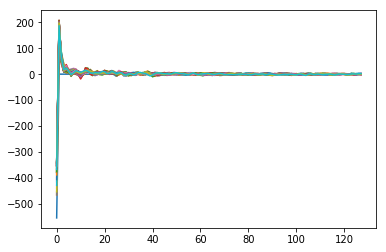

In [125]:
plt.plot(mfcc_list[100][5])
plt.show()

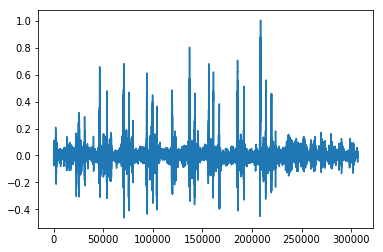

In [126]:
plt.plot(audio_list[100][4])
plt.show()

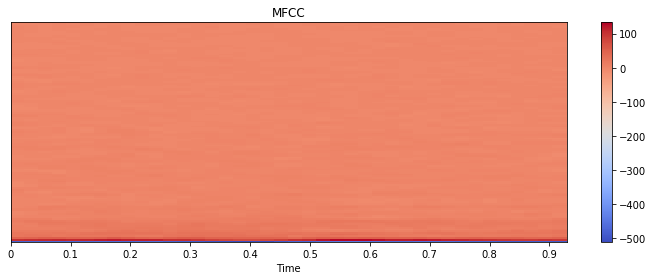

In [127]:
from librosa import display
plt.figure(figsize=(10, 4))
librosa.display.specshow(np.asarray(mfcc_list[5000][5]), x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [128]:
data_df = sql_c.createDataFrame(mfcc_list)

In [129]:
data_df.show(1)

+--------------------+---+-----+---+---+--------------------+
|                  _1| _2|   _3| _4| _5|                  _6|
+--------------------+---+-----+---+---+--------------------+
|200_2p2_Ar_mc_AKG...|  6|200.0|0.0|  2|[[-198.7150412270...|
+--------------------+---+-----+---+---+--------------------+
only showing top 1 row



The generated sample is now saved on disk

In [130]:
from pyspark.sql import DataFrameWriter
data_df.coalesce(1).write.json(path=dataset_export_path+"respiratoryDataAugmented_v1.2", mode = 'overwrite', compression='gzip')

In [131]:
## Test

In [132]:
mfcc_list_test = []
length = len(audio_list)
audio_index = 0
        
splitted_sample = extract_samples(audio_list[audio_index][4], \
                               target_length)
len(splitted_sample[0])


20000

In [133]:
import numpy as np
sample = np.array(splitted_sample[0])
stft_out = librosa.amplitude_to_db(np.abs(librosa.stft(sample)), ref=np.max)

In [134]:
mfccs = resample_and_mfcc(audio_list[audio_index][4], \
                        audio_list[audio_index][3], \
                        target_rate)
patientId = float(audio_list[audio_index][1])
diagnosisIndex = patient_diag_dict[patientId]



In [135]:
mfccs

array([[-3.61476976e+02, -3.82304731e+02, -4.29413991e+02, ...,
        -4.14415873e+02, -4.18848512e+02, -4.03131136e+02],
       [ 8.70790448e+01,  1.12955069e+02,  1.31142192e+02, ...,
         1.55740343e+02,  1.50681565e+02,  1.23128981e+02],
       [ 8.82701148e+01,  7.53980275e+01,  5.99451536e+01, ...,
         6.64852412e+01,  6.25027142e+01,  5.73630394e+01],
       ...,
       [-1.25758930e+00,  2.75597249e-01,  1.35755934e+00, ...,
        -1.02026879e+00, -5.20370460e-01,  4.29678774e-01],
       [-1.24370275e+00, -5.80079305e-01,  4.30159782e-01, ...,
         4.86003292e-01,  3.23122472e-01,  3.71753917e-02],
       [ 6.23096083e-01, -1.55550935e-01, -1.04806581e+00, ...,
         1.57699997e+00,  6.16809725e-01, -4.82587218e-01]])

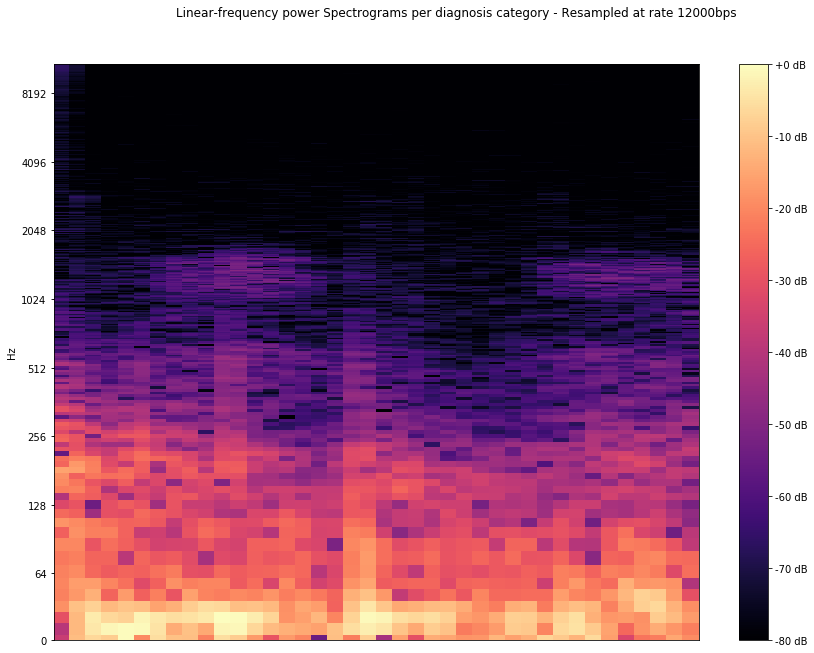

In [136]:
from librosa.display import *
fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Linear-frequency power Spectrograms per diagnosis category - Resampled at rate 12000bps")
librosa.display.specshow(stft_out, y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.show()

In [137]:
mfccs.shape

(128, 469)

In [138]:
sc.stop()